In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px

sns.set_theme()

# Functions

In [3]:
# Definisci una funzione per mappare i paesi alle regioni
def assign_region(country):
    country = HDR_ISO_country[country]
    if country in Asia:
        return 'EAP'
    elif country in Europe_Central_Asia:
        return 'ECA'
    elif country in Weastern_Europe:
        return 'WE'
    elif country in North_America:
        return 'NA'
    elif country in Arab_states:
        return 'AS'
    elif country in Oceania:
        return 'OC'
    elif country in Areas:
        return 'AREA'

In [4]:
def Pivoting(df): # Function to pivot the dataframe
    df_r = df.pivot(index=['iso3','hdicode','region','year'], columns='indicator_name', values='value').reset_index()
    df_r.reset_index(inplace=True)
    df_r.columns.name = None
    df_r.drop(columns=['index'], inplace=True)
    df_r['year'] = pd.to_datetime(df_r['year'], format='%Y',errors='coerce').dt.year
    return df_r

In [5]:
def PrepareData(df,ind): # Function to prepare the data for analysis
    Panel = df.copy()
    shift = ind.replace('_value', '') + '_shifted'
    Panel[shift] = Panel.groupby('iso3')[ind].shift(1)
    Panel.dropna(subset = shift ,inplace=True) # Drop rows with NaN values
    return Panel

In [6]:
def Regression(Panel,independent_vars,dependent_var): # Function to run the regression
    L = ['iso3','year']
    L.extend(independent_vars)
    L.append(dependent_var)
    model_df = Panel[L].copy()
    model_df = model_df.set_index(['iso3', 'year'])
    # Drop rows with NaN values only in the independent and dependent variable columns
    model_df = model_df.dropna(subset=independent_vars + [dependent_var])
    model_df[independent_vars] = model_df[independent_vars].apply(pd.to_numeric, errors='coerce')
    model_df[dependent_var] = model_df[dependent_var].apply(pd.to_numeric, errors='coerce')

    Y = model_df[dependent_var]
    X = model_df[independent_vars]
    X = sm.add_constant(X)

    mod_fe = PanelOLS(Y,X, entity_effects=True, time_effects=True)
    results = mod_fe.fit(cov_type='clustered',cluster_entity=True)

    return results.summary

# Data loading and preparation

## Data Loading

In [7]:
path = 'Datasets/'

gdp_pc_ppp = pd.read_csv(path + 'GDP per capita, PPP (current international)/WB_WDI_NY_GDP_PCAP_PP_CD.csv') # GDP per capita, PPP (current international $)
hdr = pd.read_csv(path + 'HDR/HDR25_Composite_indices_complete_time_series.csv',encoding='latin1') # Human Development Index
hdr_labels = pd.read_excel(path + 'HDR/HDR25_Composite_indices_metadata.xlsx', sheet_name = 'codebook') # Human Development
schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data
schooling_labels = pd.read_csv(path+'UNESCO/OPRI_LABEL.csv') # Schooling labels
gs = pd.read_csv(path + 'GenderStatistics/GS.csv') # Globalization data

/var/folders/pl/qxmk8x1d1m586z4_j013bvqw0000gn/T/ipykernel_10931/247098959.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data


## Data preparation

In [8]:
GS = gs.copy()
GS = GS.drop(columns=['Unnamed: 0'])
GS = GS.rename(columns={'REF_AREA': 'iso3', 'YEAR': 'year'})

### HDR

In [9]:
HDR_ISO_country = {hdr['iso3'][i]:hdr['country'][i] for i in range(len(hdr))}

In [10]:
hdr_labels.drop(columns=['Time series'], inplace=True)
hdr_labels.dropna(subset=['Short name'], inplace=True)
hdr_labels.rename(columns={'Full name': 'indicator_name', 'Short name': 'indicator'}, inplace=True)

In [11]:
HDR = hdr.copy()
df_melted = HDR.melt(id_vars=['iso3', 'country', 'hdicode', 'region', 'hdi_rank_2023'], var_name='indicator_year', value_name='value') # Melt the dataframe to long format
df_melted[['indicator', 'year']] = df_melted['indicator_year'].str.extract(r'([a-z0-9_]+)_(\d{4})')
df_final = df_melted[['iso3','hdicode','region','year', 'indicator', 'value']] # Reorder and select final columns
HDR = pd.merge(hdr_labels, df_final, on=['indicator'], how='right') # Merge with labels

In [12]:
North_America = ['Canada','United States'] 
Oceania = ['Australia','New Zealand'] 
Asia = ['Hong Kong, China (SAR)','Korea (Republic of)','Japan'] 
Europe_Central_Asia = ['Cyprus','Russian Federation','Israel'] 
Weastern_Europe = ['Andorra', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 
                   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 
                   'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 
                   'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'San Marino', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland','United Kingdom']
Arab_states = ['Algeria', 'Bahrain', 'Djibouti', 'Egypt', 'Iraq', 'Jordan']
Areas = ['Very high human development', 'High human development',
       'Medium human development', 'Low human development', 'Arab States',
       'East Asia and the Pacific', 'Europe and Central Asia',
       'Latin America and the Caribbean', 'South Asia',
       'Sub-Saharan Africa', 'World']

In [13]:
region_labels = {
    'ECA': 'Europe & Central Asia',
    'AS':  'Arab States',
    'SSA': 'Sub-Saharan Africa', 
    'LAC': 'Latin America & Caribbean',
    'SA':  'South Asia',
    'EAP': 'East Asia & Pacific',
    'AS':  'Arab States',
    'NA': 'North America',
    'WE': 'Western Europe',
    'OC': 'Oceania'
}

In [14]:
h = HDR[HDR['region'].isna()].copy()
h.loc[:,'region'] = h.loc[:,'iso3'].apply(assign_region)
HDR = pd.concat([HDR[~HDR['region'].isna()], h], ignore_index=True) # Concatenate the two dataframes
HDR.dropna(subset=['value'], inplace=True) # Drop rows with NaN values in the region column
HDR = HDR[HDR['region'] != 'AREA']

In [15]:
HDI_indicators = ['hdi', 'le', 'eys', 'mys', 'gnipc']
GDI_indicators = ['gdi_group', 'gdi', 'hdi_f', 'le_f', 'eys_f', 'mys_f', 'gni_pc_f', 'hdi_m', 'le_m', 'eys_m', 'mys_m', 'gni_pc_m']
IHDI_indicators = ['ihdi', 'coef_ineq', 'loss', 'ineq_le', 'ineq_edu', 'ineq_inc']
GII_indicators = ['gii_rank', 'gii', 'mmr', 'abr', 'se_f', 'se_m', 'pr_f', 'pr_m', 'lfpr_f', 'lfpr_m']
PHDI_indicators = ['rankdiff_hdi_phdi', 'phdi', 'diff_hdi_phdi', 'co2_prod', 'mf']
Population_indicator = ['pop_total']

In [16]:
hdi = HDR[HDR['indicator'].isin(HDI_indicators+Population_indicator)]
gdi = HDR[HDR['indicator'].isin(GDI_indicators+Population_indicator)]
ihdi = HDR[HDR['indicator'].isin(IHDI_indicators+Population_indicator)]
gii = HDR[HDR['indicator'].isin(GII_indicators+Population_indicator)]
phdi = HDR[HDR['indicator'].isin(PHDI_indicators+Population_indicator)]

In [17]:
HDI = Pivoting(hdi)
GDI = Pivoting(gdi)
IHDI = Pivoting(ihdi)
GII = Pivoting(gii)

In [18]:
HDR_idx = {'hdi': 'Human Development Index (value)', 'gii': 'Gender Inequality Index (value)', 
           'gdi': 'Gender Development Index (value)', 'ihdi': 'Inequality-adjusted Human Development Index (value)'}

#### GDP per Capita PPP

In [19]:
WB_ISO_country = {gdp_pc_ppp['REF_AREA_ID'][i]:gdp_pc_ppp['REF_AREA_NAME'][i] for i in range(len(gdp_pc_ppp))}

In [20]:
GDP = gdp_pc_ppp.copy()
GDP = GDP[['REF_AREA_ID','TIME_PERIOD','OBS_VALUE']]
GDP.rename(columns={'REF_AREA_ID':'iso3','TIME_PERIOD':'year','OBS_VALUE':'GDP'},inplace=True)
GDP['year'] = pd.to_datetime(GDP['year'], format='%Y',errors='coerce').dt.year
GDP['logGDP'] = np.log(GDP['GDP'])

#### Schooling

In [21]:
SCH = schooling.copy()
SCH['INDICATOR_ID'] = SCH['INDICATOR_ID'].astype(str)
SCH = SCH[SCH['INDICATOR_ID'].str.contains('NART', na=False)] 
SCH = SCH.drop(columns=['MAGNITUDE','QUALIFIER'])
SCH = pd.merge(schooling_labels,SCH,how='left',on='INDICATOR_ID') # Merge the labels with the schooling data
SCH['YEAR'] = pd.to_datetime(SCH['YEAR'], format='%Y',errors='coerce').dt.year 

In [22]:
Primary = SCH[SCH['INDICATOR_ID'].str.contains('NART.1', na=False)] # Filter for primary education
Secondary = SCH[SCH['INDICATOR_ID'].str.contains('NART.2', na=False)] # Filter for secondary education
Tertiary = SCH[SCH['INDICATOR_ID'].str.contains('NART.3', na=False)] # Filter for tertiary education

In [23]:
P = Primary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
S = Secondary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
T = Tertiary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()

In [24]:
P.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
S.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
T.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)

# Panels

In [25]:
# GDP and GII
GDP_GII = pd.merge(GDP, GII, on=["iso3", "year"],how="inner")
GDP_GII.columns.name = None
Panel_GII = PrepareData(GDP_GII,HDR_idx['gii']) # Prepare the GII data
Panel_GII = Panel_GII[~Panel_GII['iso3'].isin(['KWT', 'ARE', 'SAU', 'QAT'])] # Filter the GII data to include only countries present in the GDP data

# GDP and GII + HDI_female
GDP_GII_GDI = pd.merge(GDP_GII, GDI, on=["iso3", "year", "hdicode", "region"],how="inner")
GDP_GII_GDI.columns.name = None
Panel_GII_GDI = PrepareData(GDP_GII_GDI,HDR_idx['gii']) # Prepare the GII data
Panel_GII_GDI = PrepareData(Panel_GII_GDI,'HDI female (value)') # Prepare the GII data

# GDP and HDI_female
GDP_GDI = pd.merge(GDP, GDI, on=["iso3", "year"],how="inner")
GDP_GDI.columns.name = None
Panel_GDI = PrepareData(GDP_GDI,'HDI female (value)') # Prepare the GII data

# GDP and HDI
GDP_HDI = pd.merge(GDP, HDI, on=["iso3", "year"],how="inner")
GDP_HDI.columns.name = None
Panel_HDI = PrepareData(GDP_HDI,HDR_idx['hdi']) # Prepare the GII data

# HDI and GII
HDI_GII = pd.merge(HDI, GII, on=["iso3", "year","hdicode","region"],how="inner")
HDI_GII.columns.name = None
Panel_HDI_GII = PrepareData(HDI_GII,HDR_idx['gii']) # Prepare the GII data

# HDI_female and GDI
GDI_GII = pd.merge(GDI, GII, on=["iso3", "year"],how="inner")
GDI_GII.columns.name = None


# Plots

In [26]:
image_path = '/Users/gianlucafilesi/Library/CloudStorage/OneDrive-EDHEC/04 THESIS/Images/Results/'

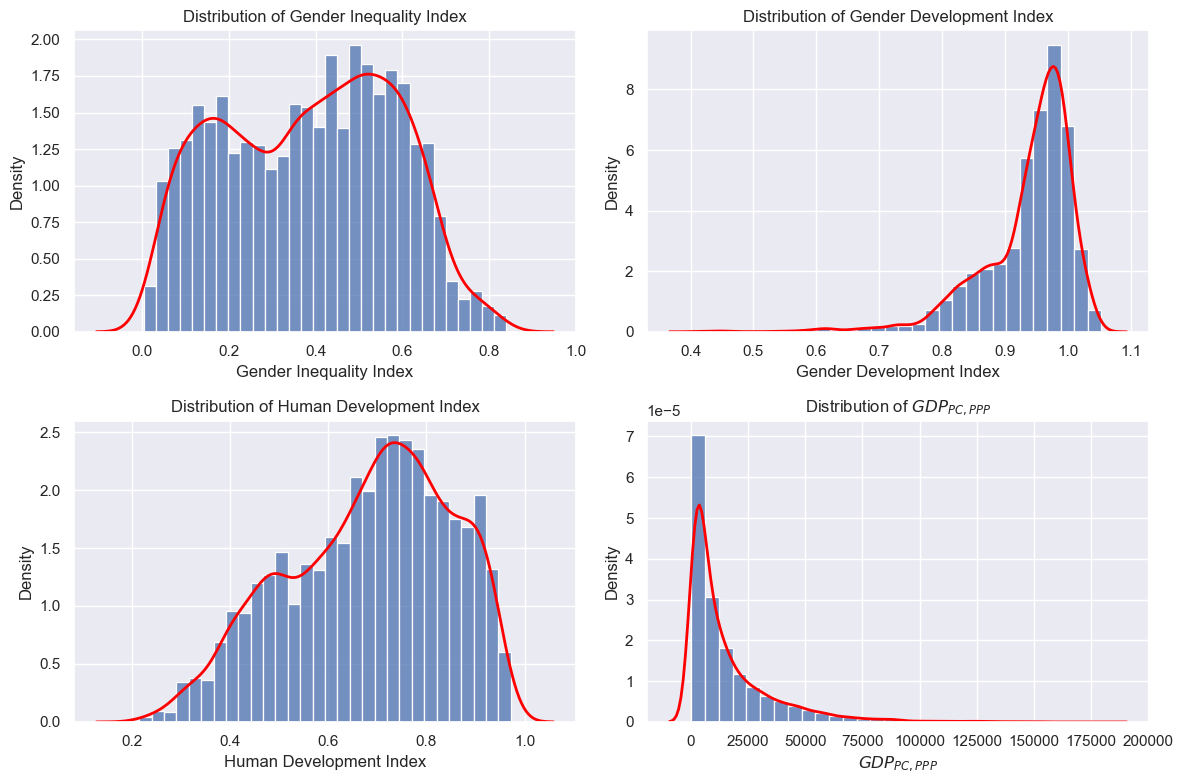

In [35]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))
sns.histplot(data=GII, x='Gender Inequality Index (value)', bins=30, stat="density", ax=ax[0,0])
sns.kdeplot(data=GII, x='Gender Inequality Index (value)', color="red", lw=2, ax=ax[0,0])
ax[0,0].set_xlabel('Gender Inequality Index')
ax[0,0].set_ylabel('Density')
ax[0,0].set_title('Distribution of Gender Inequality Index')

sns.histplot(data=GDI, x='Gender Development Index (value)', bins=30, stat="density", ax=ax[0,1])
sns.kdeplot(data=GDI, x='Gender Development Index (value)', color="red", lw=2, ax=ax[0,1])
ax[0,1].set_xlabel('Gender Development Index')
ax[0,1].set_ylabel('Density')
ax[0,1].set_title('Distribution of Gender Development Index')

sns.histplot(data=HDI, x='Human Development Index (value)', bins=30, stat="density", ax=ax[1,0])
sns.kdeplot(data=HDI, x='Human Development Index (value)', color="red", lw=2, ax=ax[1,0])
ax[1,0].set_xlabel('Human Development Index')
ax[1,0].set_ylabel('Density')
ax[1,0].set_title('Distribution of Human Development Index')

sns.histplot(data=GDP, x='GDP', bins=30, stat="density", ax=ax[1,1])
sns.kdeplot(data=GDP, x='GDP', color="red", lw=2, ax=ax[1,1])
ax[1,1].set_xlabel(r'$GDP_{PC,PPP}$')
ax[1,1].set_ylabel('Density')
ax[1,1].set_title(r'Distribution of $GDP_{PC,PPP}$')

plt.tight_layout()
plt.savefig(image_path + 'Distribution.pdf', dpi=1500, bbox_inches='tight')
plt.show()

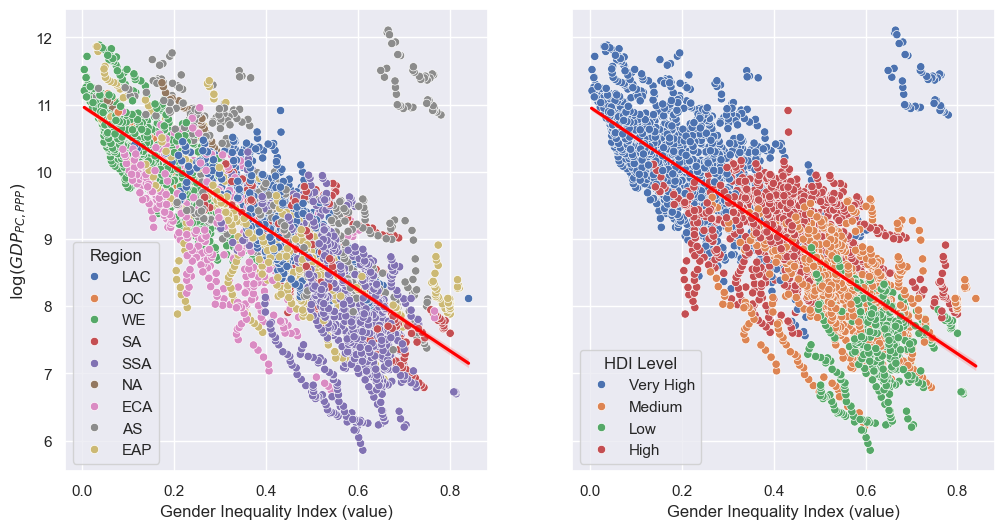

                                         Gender Inequality Index (value)_shifted  \
Gender Inequality Index (value)_shifted                                 1.000000   
logGDP                                                                 -0.779201   

                                           logGDP  
Gender Inequality Index (value)_shifted -0.779201  
logGDP                                   1.000000  


In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scatter plot with trend line
sns.scatterplot(data=PrepareData(GDP_GII,HDR_idx['gii']), x=HDR_idx['gii']+'_shifted', y='logGDP', hue='region', ax=ax[0])
sns.regplot(data=PrepareData(GDP_GII,HDR_idx['gii']), x=HDR_idx['gii']+'_shifted', y='logGDP', scatter=False, ax=ax[0], color='red', line_kws={"label": "Trend Line"})
ax[0].legend(title='Region')
ax[0].set_xlabel('Gender Inequality Index (value)')
ax[0].set_ylabel(r'$\log (GDP_{PC,PPP})$')

sns.scatterplot(data=PrepareData(GDP_GII,HDR_idx['gii']), x=HDR_idx['gii']+'_shifted', y='logGDP', hue='hdicode',ax=ax[1])
sns.regplot(data=PrepareData(GDP_GII,HDR_idx['gii']), x=HDR_idx['gii'], y='logGDP', scatter=False, ax=ax[1], color='red', line_kws={"label": "Trend Line"})
ax[1].legend(title='HDI Level')
ax[1].set_xlabel('Gender Inequality Index (value)')
ax[1].set_ylabel(r'$\log (GDP_{PC,PPP})$')

plt.savefig(image_path + 'GDP_GII.pdf', dpi=1500, bbox_inches='tight')
plt.show()

C = PrepareData(GDP_GII,HDR_idx['gii'])
C = C[[HDR_idx['gii']+'_shifted','logGDP']]
C = C.dropna()
print(C.corr())

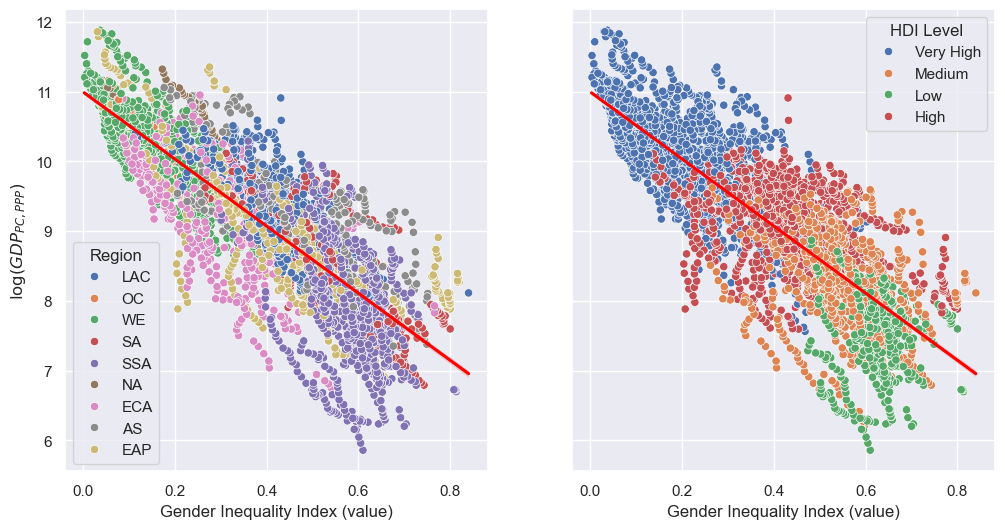

                                         Gender Inequality Index (value)_shifted  \
Gender Inequality Index (value)_shifted                                 1.000000   
logGDP                                                                 -0.836058   

                                           logGDP  
Gender Inequality Index (value)_shifted -0.836058  
logGDP                                   1.000000  


In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scatter plot with trend line
sns.scatterplot(data=Panel_GII, x=HDR_idx['gii']+'_shifted', y='logGDP', hue='region', ax=ax[0])
sns.regplot(data=Panel_GII, x=HDR_idx['gii'], y='logGDP', scatter=False, ax=ax[0], color='red', line_kws={"label": "Trend Line"})
ax[0].legend(title='Region')
ax[0].set_xlabel('Gender Inequality Index (value)')
ax[0].set_ylabel(r'$\log (GDP_{PC,PPP})$')

sns.scatterplot(data=Panel_GII, x=HDR_idx['gii']+'_shifted', y='logGDP', hue='hdicode',ax=ax[1])
sns.regplot(data=Panel_GII, x=HDR_idx['gii'], y='logGDP', scatter=False, ax=ax[1], color='red', line_kws={"label": "Trend Line"})
ax[1].legend(title='HDI Level')
ax[1].set_xlabel('Gender Inequality Index (value)')
ax[1].set_ylabel(r'$\log (GDP_{PC,PPP})$')

plt.savefig(image_path + 'GDP_GII_noAS.pdf', dpi=1500, bbox_inches='tight')
plt.show()

C = Panel_GII[[HDR_idx['gii']+'_shifted','logGDP']]
C = C.dropna()
print(C.corr())

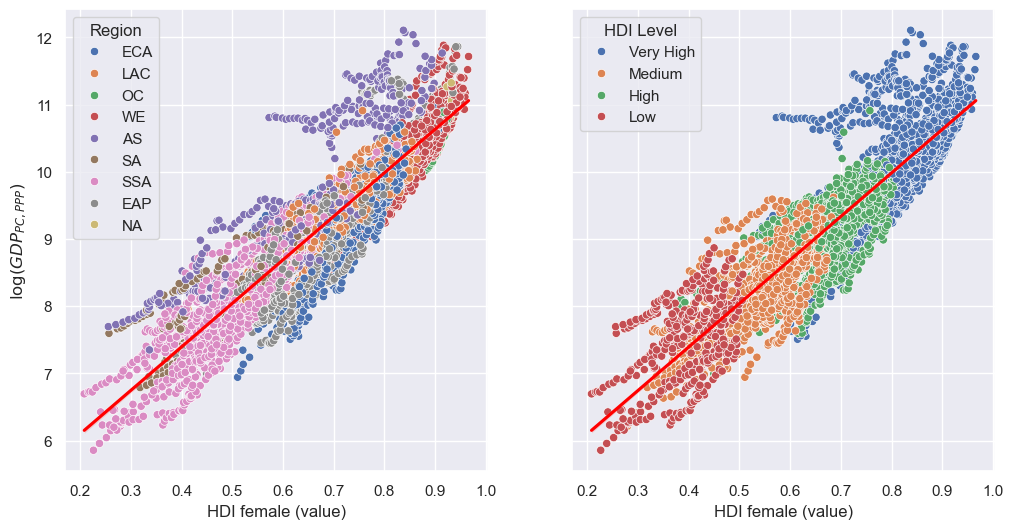

                            HDI female (value)_shifted   logGDP
HDI female (value)_shifted                     1.00000  0.91137
logGDP                                         0.91137  1.00000


In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scatter plot with trend line
sns.scatterplot(data=Panel_GDI, x='HDI female (value)'+'_shifted', y='logGDP', hue='region', ax=ax[0])
sns.regplot(data=Panel_GDI, x='HDI female (value)'+'_shifted', y='logGDP', scatter=False, ax=ax[0], color='red', line_kws={"label": "Trend Line"})
ax[0].legend(title='Region')
ax[0].set_xlabel('HDI female (value)')
ax[0].set_ylabel(r'$\log (GDP_{PC,PPP})$')

sns.scatterplot(data=Panel_GDI, x='HDI female (value)'+'_shifted', y='logGDP', hue='hdicode',ax=ax[1])
sns.regplot(data=Panel_GDI, x='HDI female (value)'+'_shifted', y='logGDP', scatter=False, ax=ax[1], color='red', line_kws={"label": "Trend Line"})
ax[1].legend(title='HDI Level')
ax[1].set_xlabel('HDI female (value)')
ax[1].set_ylabel(r'$\log (GDP_{PC,PPP})$')


plt.savefig(image_path + 'GDP_HDI_female.pdf', dpi=1500, bbox_inches='tight')
plt.show()

C = Panel_GDI[['HDI female (value)'+'_shifted','logGDP']]
C = C.dropna()
print(C.corr())

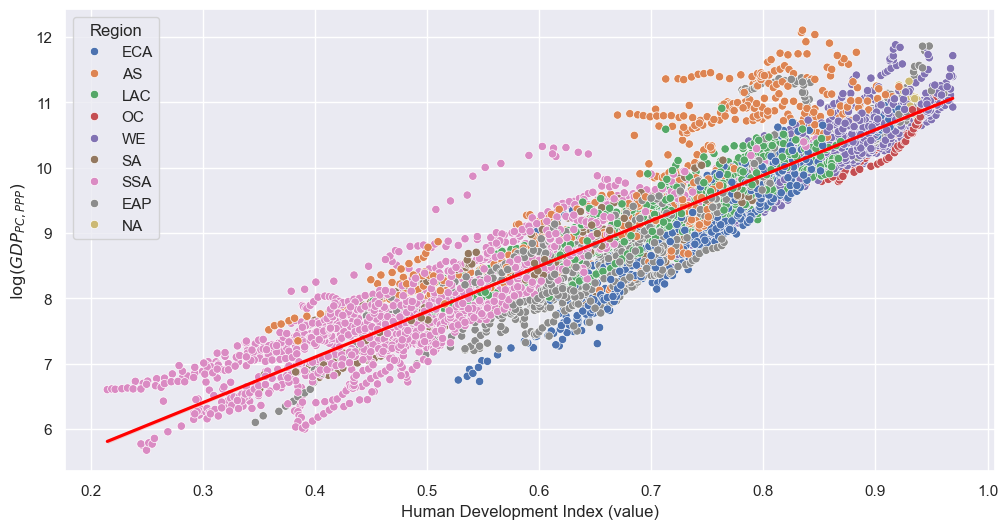

                                         Human Development Index (value)_shifted  \
Human Development Index (value)_shifted                                 1.000000   
logGDP                                                                  0.927144   

                                           logGDP  
Human Development Index (value)_shifted  0.927144  
logGDP                                   1.000000  


In [39]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_HDI, x=HDR_idx['hdi']+'_shifted', y='logGDP', hue='region',)
sns.regplot(data=Panel_HDI, x=HDR_idx['hdi']+'_shifted', y='logGDP', scatter=False, color='red', line_kws={"label": "Trend Line"})
plt.ylabel(r'$\log (GDP_{PC,PPP})$')
plt.xlabel('Human Development Index (value)')
plt.legend(title='Region')

plt.savefig(image_path + 'GDP_HDI.pdf', dpi=1500, bbox_inches='tight')
plt.show()

C = Panel_HDI[[HDR_idx['hdi']+'_shifted','logGDP']]
C = C.dropna()
print(C.corr())


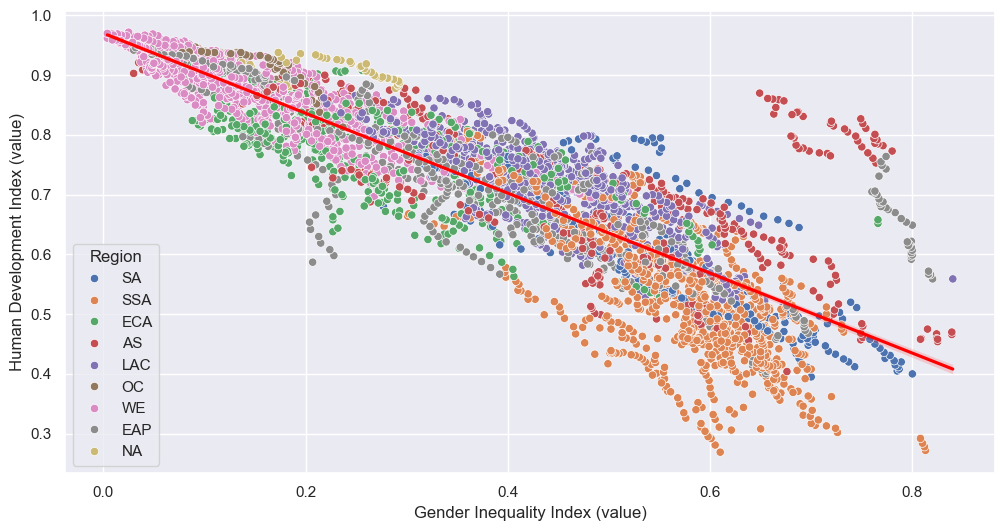

                                         Gender Inequality Index (value)_shifted  \
Gender Inequality Index (value)_shifted                                 1.000000   
Human Development Index (value)                                        -0.868187   

                                         Human Development Index (value)  
Gender Inequality Index (value)_shifted                        -0.868187  
Human Development Index (value)                                 1.000000  


In [40]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_HDI_GII, x=HDR_idx['gii']+'_shifted', y=HDR_idx['hdi'], hue='region')
sns.regplot(data=Panel_HDI_GII, x=HDR_idx['gii']+'_shifted', y=HDR_idx['hdi'], scatter=False, color='red', line_kws={"label": "Trend Line"})
plt.ylabel(HDR_idx['hdi'])
plt.xlabel(HDR_idx['gii'])
plt.legend(title='Region')

plt.savefig(image_path + 'HDI_GII.pdf', dpi=1500, bbox_inches='tight')
plt.show()

C = Panel_HDI_GII[[HDR_idx['gii']+'_shifted',HDR_idx['hdi']]]
C = C.dropna()
print(C.corr())

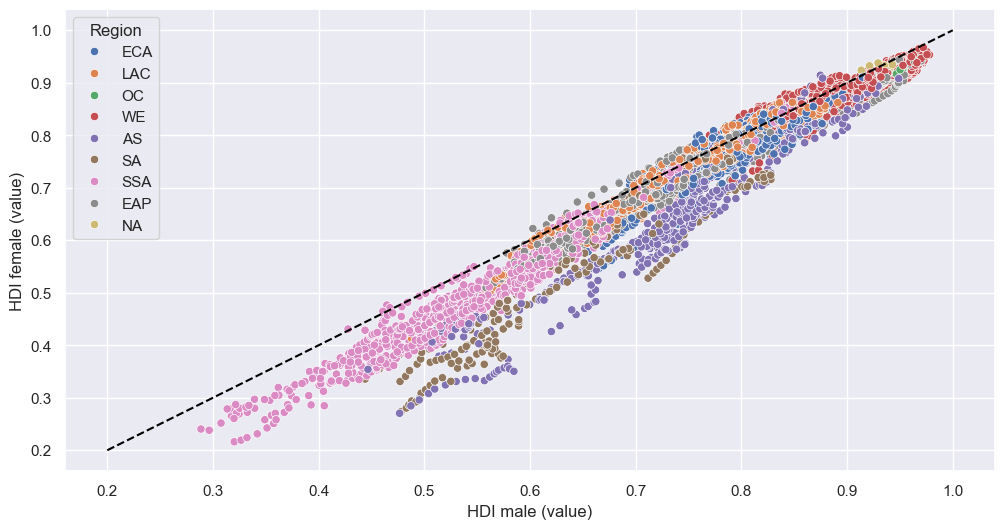

In [41]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_GDI, y='HDI female (value)', x='HDI male (value)', hue='region')
plt.plot([0.2, 1], [0.2, 1], color='black', linestyle='--')
plt.legend(title='Region')

plt.savefig(image_path + 'HDI_Female_vs_Male.pdf', dpi=1500, bbox_inches='tight')
plt.show()

In [34]:
M = Panel_GDI.copy() # Drop rows with NaN values
M.dropna(subset = ['HDI female (value)','HDI male (value)'])
np.corrcoef(M['HDI female (value)'], M['HDI male (value)'])

array([[1.        , 0.97706484],
       [0.97706484, 1.        ]])